In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/1_pt"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from Dataloader import *
from PSFNetv2 import *

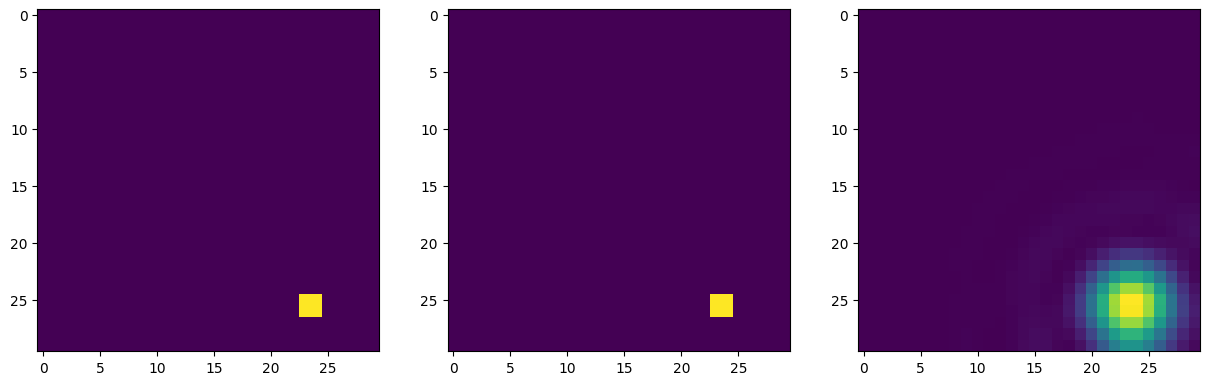

In [3]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
maskSize = np.linalg.norm((0,0),mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask, adjPts=20, randomPts=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(sourcePts),dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0)


tensor([[[-2.2222],
         [-2.4500],
         [-2.2278],
         [-2.4556]],

        [[-0.6500],
         [-0.5889],
         [-0.7556],
         [-0.6944]],

        [[-0.8889],
         [-0.8500],
         [-1.0278],
         [-0.9889]],

        ...,

        [[-2.5611],
         [-2.7778],
         [-2.6778],
         [-2.8944]],

        [[-0.0556],
         [-0.0944],
         [-0.0500],
         [-0.0889]],

        [[-1.9389],
         [-2.0000],
         [-2.1444],
         [-2.2056]]], grad_fn=<UnsafeViewBackward0>)
tensor([[[-0.0134],
         [-0.0067],
         [-0.0335],
         [-0.0268]],

        [[-3.3857],
         [-3.6472],
         [-3.5533],
         [-3.8148]],

        [[-1.2135],
         [-1.3543],
         [-1.3409],
         [-1.4817]],

        ...,

        [[-2.2326],
         [-2.4806],
         [-2.1990],
         [-2.4471]],

        [[-2.6885],
         [-2.6818],
         [-2.9633],
         [-2.9566]],

        [[-1.2403],
         [-1.1934],

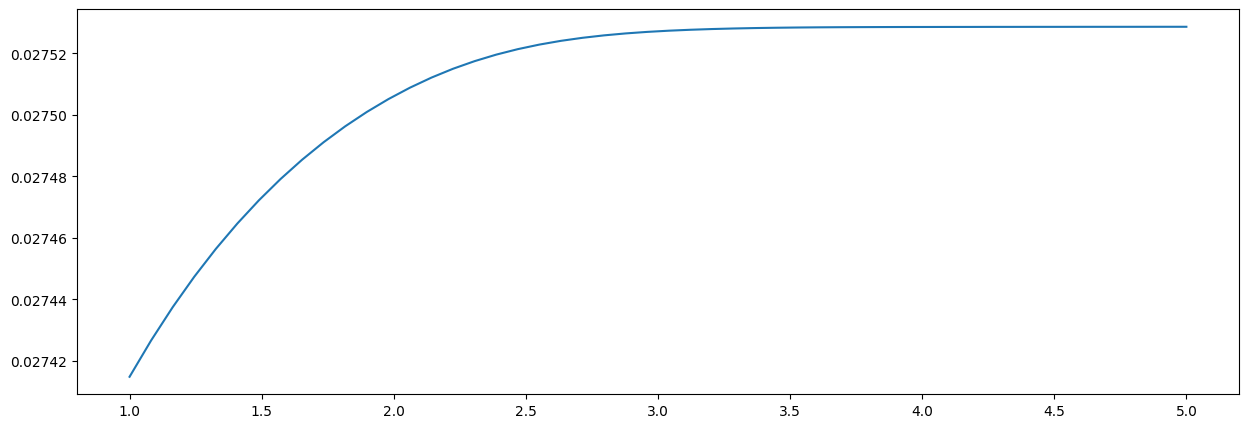

In [6]:
#Perform a global serarch on what the scaling const is
x = np.linspace(0,5,50)
y = []

for i in x:
    model.polynomial_weights.weight.data[0] = -10**i
    average_running_loss = 0
    for j, data in enumerate(dataloader):
        inputs, outputs = data
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        average_running_loss += loss.item()
    average_running_loss /= len(dataloader)
    y.append(average_running_loss)

plt.plot(x,y)
model.polynomial_weights.weight.data[0] = -10**x[np.argmin(y)]
print("Best scaling const is: ", -10**x[np.argmin(y)])

In [7]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=400, minLoss=0.01)

print(model.polynomial_weights.weight.data)

oldOut = InverseMatrix(oldOut,mask,sourcePts,learningRate=1,randomPts=0,adjPts=20,model=model)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')


tensor([[[-1.4444],
         [-1.4278],
         [-1.6278],
         [-1.6111]],

        [[-3.6000],
         [-3.8056],
         [-3.8056],
         [-4.0111]],

        [[-2.7778],
         [-3.0056],
         [-2.8944],
         [-3.1222]],

        ...,

        [[-1.6556],
         [-1.6944],
         [-1.8500],
         [-1.8889]],

        [[-2.8556],
         [-3.0500],
         [-3.0278],
         [-3.2222]],

        [[-2.4722],
         [-2.6000],
         [-2.6778],
         [-2.8056]]], grad_fn=<UnsafeViewBackward0>)
tensor([[[-0.4556],
         [-0.4500],
         [-0.5611],
         [-0.5556]],

        [[-0.8278],
         [-0.9111],
         [-0.9444],
         [-1.0278]],

        [[-0.0944],
         [-0.0889],
         [-0.0556],
         [-0.0500]],

        ...,

        [[-0.3389],
         [-0.2778],
         [-0.4000],
         [-0.3389]],

        [[-0.8500],
         [-0.8889],
         [-0.9889],
         [-1.0278]],

        [[-1.8056],
         [-1.7444],

tensor([[[-0.0444],
         [-0.0278],
         [-0.0722],
         [-0.0556]],

        [[-0.5556],
         [-0.6500],
         [-0.6278],
         [-0.7222]],

        [[-2.1556],
         [-2.3611],
         [-2.2500],
         [-2.4556]],

        ...,

        [[-2.0278],
         [-2.2444],
         [-2.0111],
         [-2.2278]],

        [[-2.2056],
         [-2.2778],
         [-2.4222],
         [-2.4944]],

        [[-1.6056],
         [-1.7000],
         [-1.7778],
         [-1.8722]]], grad_fn=<UnsafeViewBackward0>)
tensor([[[-1.9222],
         [-2.0500],
         [-2.0944],
         [-2.2222]],

        [[-2.0278],
         [-2.2444],
         [-2.0556],
         [-2.2722]],

        [[-1.0778],
         [-1.0278],
         [-1.2278],
         [-1.1778]],

        ...,

        [[-1.8222],
         [-2.0278],
         [-1.8500],
         [-2.0556]],

        [[-1.8222],
         [-1.8056],
         [-2.0278],
         [-2.0111]],

        [[ 0.0000],
         [-0.0056],

/tmp/ipykernel_5039/2611858017.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  new_psf_y = model.getPSF(torch.tensor(new_psf_x))


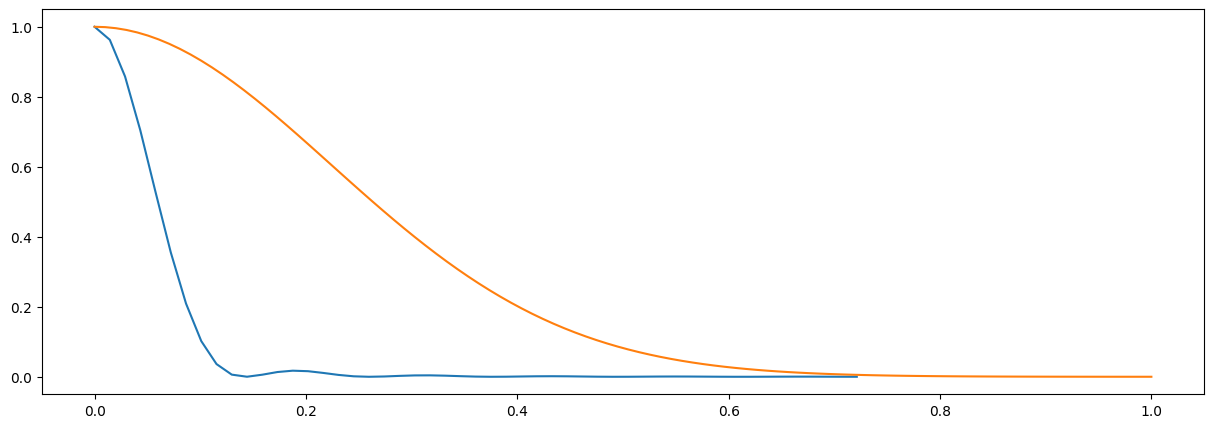

In [ ]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
new_psf_y = new_psf_y/max(new_psf_y.flatten())
plt.plot(new_psf_x,new_psf_y)
plt.show()


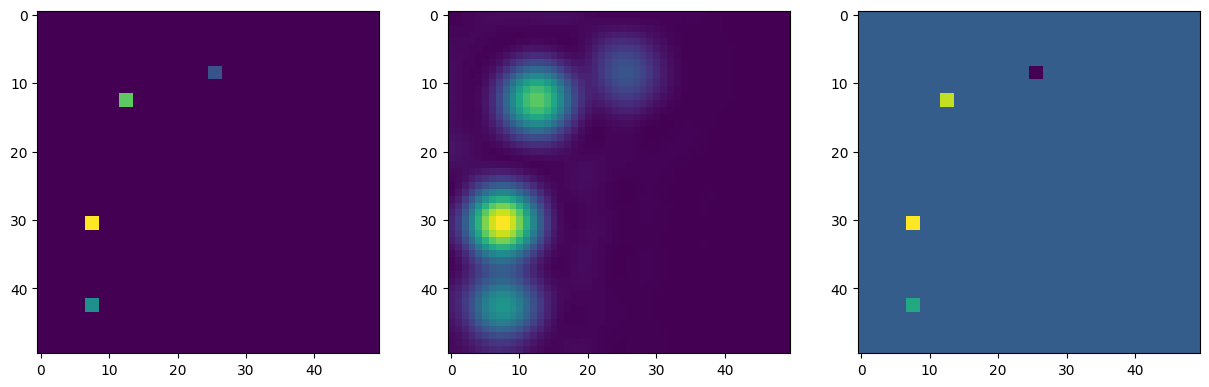

In [ ]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(oldOut)
plt.show()


array([[1.        , 0.94417062],
       [0.94417062, 1.        ]])

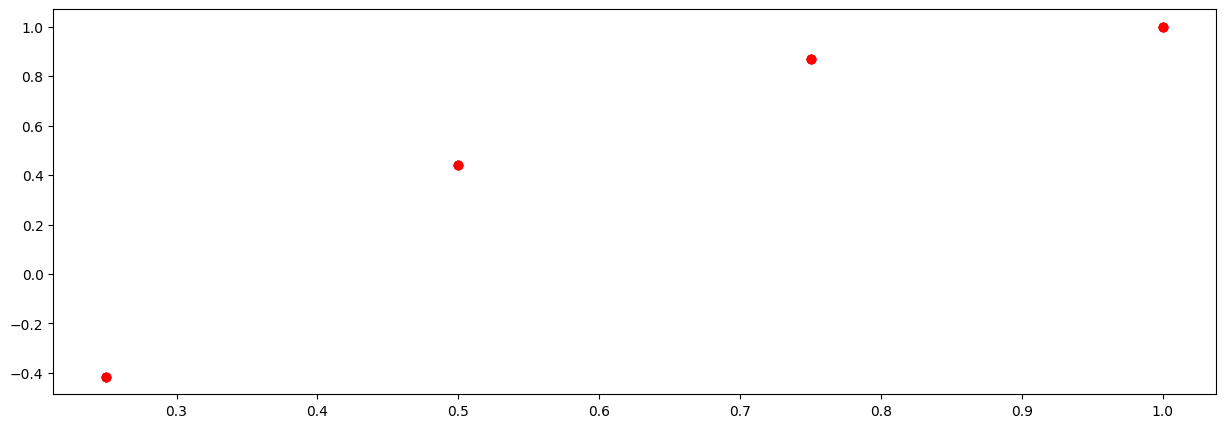

In [ ]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(oldOut[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)